In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings('ignore')

In [3]:
# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('CreditCard.csv')
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset shape: (568630, 31)
Memory usage: 134.49 MB


In [4]:
print("\n=== DATA QUALITY CHECK ===")
print(f"Missing values:\n{df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Data types:\n{df.dtypes.value_counts()}")

# Basic statistics
print(f"\n=== CLASS DISTRIBUTION ===")
class_dist = df['Class'].value_counts()
print(f"Non-Fraud (0): {class_dist[0]:,} ({class_dist[0]/len(df)*100:.2f}%)")
print(f"Fraud (1): {class_dist[1]:,} ({class_dist[1]/len(df)*100:.2f}%)")


=== DATA QUALITY CHECK ===
Missing values:
0
Duplicate rows: 0
Data types:
float64    29
int64       2
Name: count, dtype: int64

=== CLASS DISTRIBUTION ===
Non-Fraud (0): 284,315 (50.00%)
Fraud (1): 284,315 (50.00%)



=== EXPLORATORY DATA ANALYSIS ===

Amount Statistics by Class:
           mean    median      std
Class                             
0      12026.31  11996.90  6929.50
1      12057.60  12062.45  6909.75
Top 8 most important features: ['V14', 'V10', 'V12', 'V4', 'V11', 'V17', 'V16', 'V7']


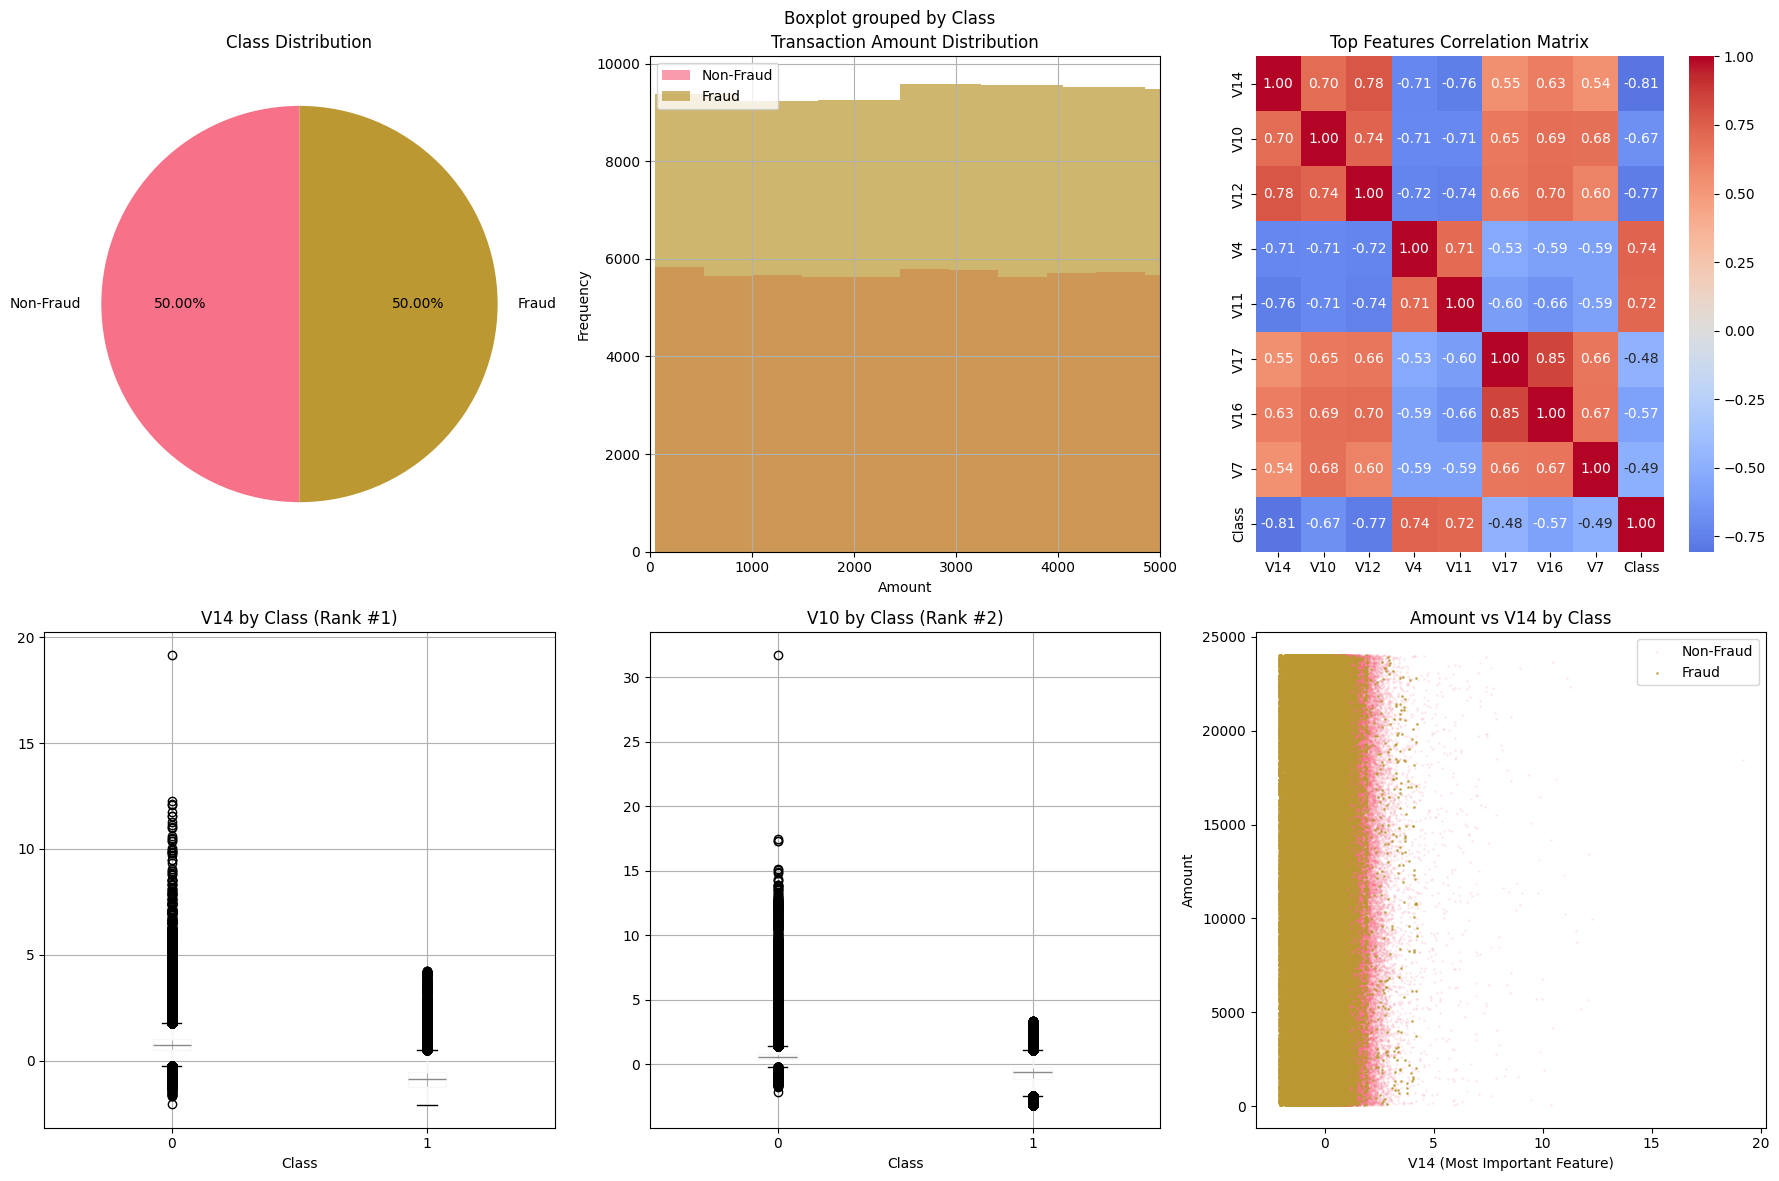

In [5]:
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Create figure for visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Class distribution
axes[0,0].pie(class_dist.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', startangle=90)
axes[0,0].set_title('Class Distribution')

# Amount distribution by class
df[df['Class']==0]['Amount'].hist(bins=50, alpha=0.7, label='Non-Fraud', ax=axes[0,1])
df[df['Class']==1]['Amount'].hist(bins=30, alpha=0.7, label='Fraud', ax=axes[0,1])
axes[0,1].set_xlabel('Amount')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Transaction Amount Distribution')
axes[0,1].legend()
axes[0,1].set_xlim(0, 5000)

# Amount statistics by class
amount_stats = df.groupby('Class')['Amount'].agg(['mean', 'median', 'std']).round(2)
print(f"\nAmount Statistics by Class:\n{amount_stats}")

# Quick feature importance analysis to identify key features
from sklearn.ensemble import RandomForestClassifier
feature_cols_temp = [col for col in df.columns if col.startswith('V')] + ['Amount']
X_temp = df[feature_cols_temp].copy()
y_temp = df['Class'].copy()

# Scale Amount for initial analysis
scaler_temp = StandardScaler()
X_temp['Amount'] = scaler_temp.fit_transform(X_temp[['Amount']])

# Quick RF to get feature importance
rf_temp = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_temp.fit(X_temp, y_temp)

# Get top important features
feature_importance_temp = pd.DataFrame({
    'feature': feature_cols_temp,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance_temp.head(8)['feature'].tolist()
print(f"Top 8 most important features: {top_features}")

# Correlation heatmap for TOP important features
corr_features = top_features + ['Class']
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,2], fmt='.2f')
axes[0,2].set_title('Top Features Correlation Matrix')

# Box plots for top 4 most important features
key_features = top_features[:4]
for i, feature in enumerate(key_features):
    row, col = (i//2 + 1, i%2)
    if row < 2:
        df.boxplot(column=feature, by='Class', ax=axes[row, col])
        axes[row, col].set_title(f'{feature} by Class (Rank #{i+1})')
        axes[row, col].set_xlabel('Class')

# Analysis using most important feature
most_important_feature = top_features[0]
axes[1,2].scatter(df[df['Class']==0][most_important_feature], df[df['Class']==0]['Amount'],
                 alpha=0.1, label='Non-Fraud', s=1)
axes[1,2].scatter(df[df['Class']==1][most_important_feature], df[df['Class']==1]['Amount'],
                 alpha=0.7, label='Fraud', s=1)
axes[1,2].set_xlabel(f'{most_important_feature} (Most Important Feature)')
axes[1,2].set_ylabel('Amount')
axes[1,2].set_title(f'Amount vs {most_important_feature} by Class')
axes[1,2].legend()

plt.tight_layout()
plt.show()

In [7]:
print("\n=== MERCHANT CATEGORY ANALYSIS ===")
# Use the most discriminative feature for merchant categorization
merchant_feature = top_features[1]  # Second most important feature
df['Merchant_Category'] = pd.cut(df[merchant_feature], bins=5, labels=['Cat_A', 'Cat_B', 'Cat_C', 'Cat_D', 'Cat_E'])

merchant_fraud = df.groupby('Merchant_Category')['Class'].agg(['count', 'sum', 'mean']).round(4)
merchant_fraud.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
print(f"Fraud Analysis by Merchant Category (based on {merchant_feature}):")
print(merchant_fraud)


=== MERCHANT CATEGORY ANALYSIS ===
Fraud Analysis by Merchant Category (based on V10):
                   Total_Transactions  Fraud_Count  Fraud_Rate
Merchant_Category                                             
Cat_A                          566921       284315      0.5015
Cat_B                            1559            0      0.0000
Cat_C                             149            0      0.0000
Cat_D                               0            0         NaN
Cat_E                               1            0      0.0000


In [8]:
print("\n=== TRANSACTION TYPE ANALYSIS ===")
# Create transaction types based on amount ranges
amount_bins = [0, 100, 500, 2000, float('inf')]
amount_labels = ['Small', 'Medium', 'Large', 'Very_Large']
df['Transaction_Type'] = pd.cut(df['Amount'], bins=amount_bins, labels=amount_labels)

trans_type_fraud = df.groupby('Transaction_Type')['Class'].agg(['count', 'sum', 'mean']).round(4)
trans_type_fraud.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
print("Fraud Analysis by Transaction Type:")
print(trans_type_fraud)


=== TRANSACTION TYPE ANALYSIS ===
Fraud Analysis by Transaction Type:
                  Total_Transactions  Fraud_Count  Fraud_Rate
Transaction_Type                                             
Small                           1190          594      0.4992
Medium                          9599         4719      0.4916
Large                          34997        17298      0.4943
Very_Large                    522844       261704      0.5005


In [9]:
print("\n=== DATA PREPROCESSING ===")

# Feature importance analysis before final modeling
print(f"Using top {len(top_features)} most important features for modeling:")
for i, feature in enumerate(top_features):
    importance_score = feature_importance_temp[feature_importance_temp['feature']==feature]['importance'].iloc[0]
    print(f"  {i+1}. {feature}: {importance_score:.4f}")

# Use only top important features for modeling
feature_cols = top_features
X = df[feature_cols].copy()
y = df['Class'].copy()

# Scale features (especially Amount if it's in top features)
scaler = StandardScaler()
if 'Amount' in feature_cols:
    X['Amount'] = scaler.fit_transform(X[['Amount']])

print(f"\nUsing {len(feature_cols)} most important features for final models")

# No class imbalance handling needed - using full dataset
print(f"Using full dataset: {X.shape[0]:,} samples")
print(f"Class distribution:\n{y.value_counts()}")

# Split data directly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


=== DATA PREPROCESSING ===
Using top 8 most important features for modeling:
  1. V14: 0.1962
  2. V10: 0.1508
  3. V12: 0.0858
  4. V4: 0.0852
  5. V11: 0.0820
  6. V17: 0.0778
  7. V16: 0.0747
  8. V7: 0.0435

Using 8 most important features for final models
Using full dataset: 568,630 samples
Class distribution:
Class
0    284315
1    284315
Name: count, dtype: int64


In [10]:
print("\n=== MACHINE LEARNING MODELS ===")


rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

dt_model = DecisionTreeClassifier(
    max_depth=10,
    random_state=42,
    min_samples_split=20,
    min_samples_leaf=10
)

nb_model = GaussianNB()

models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Decision Tree': dt_model,
    'Naive Bayes': nb_model
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc_score:.4f}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))


=== MACHINE LEARNING MODELS ===

--- Random Forest ---
Accuracy: 0.9783
AUC Score: 0.9980

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56863
           1       1.00      0.96      0.98     56863

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726


--- Gradient Boosting ---
Accuracy: 0.9908
AUC Score: 0.9994

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726


--- Decision Tree ---
Accuracy: 0.9779
AUC Score: 0.9965

Classification Report:
              precision    recall  f1-score   support

        


=== DETAILED CONFUSION MATRICES ===

Random Forest Detailed Metrics:
  True Negatives (Correct Non-Fraud): 56,616
  False Positives (False Fraud Alerts): 247
  False Negatives (Missed Fraud): 2,221
  True Positives (Caught Fraud): 54,642
  Precision (Fraud Detection Accuracy): 0.996
  Recall (Fraud Catch Rate): 0.961
  Specificity (Non-Fraud Accuracy): 0.996

Gradient Boosting Detailed Metrics:
  True Negatives (Correct Non-Fraud): 56,469
  False Positives (False Fraud Alerts): 394
  False Negatives (Missed Fraud): 649
  True Positives (Caught Fraud): 56,214
  Precision (Fraud Detection Accuracy): 0.993
  Recall (Fraud Catch Rate): 0.989
  Specificity (Non-Fraud Accuracy): 0.993

Decision Tree Detailed Metrics:
  True Negatives (Correct Non-Fraud): 55,532
  False Positives (False Fraud Alerts): 1,331
  False Negatives (Missed Fraud): 1,178
  True Positives (Caught Fraud): 55,685
  Precision (Fraud Detection Accuracy): 0.977
  Recall (Fraud Catch Rate): 0.979
  Specificity (Non-Fraud A

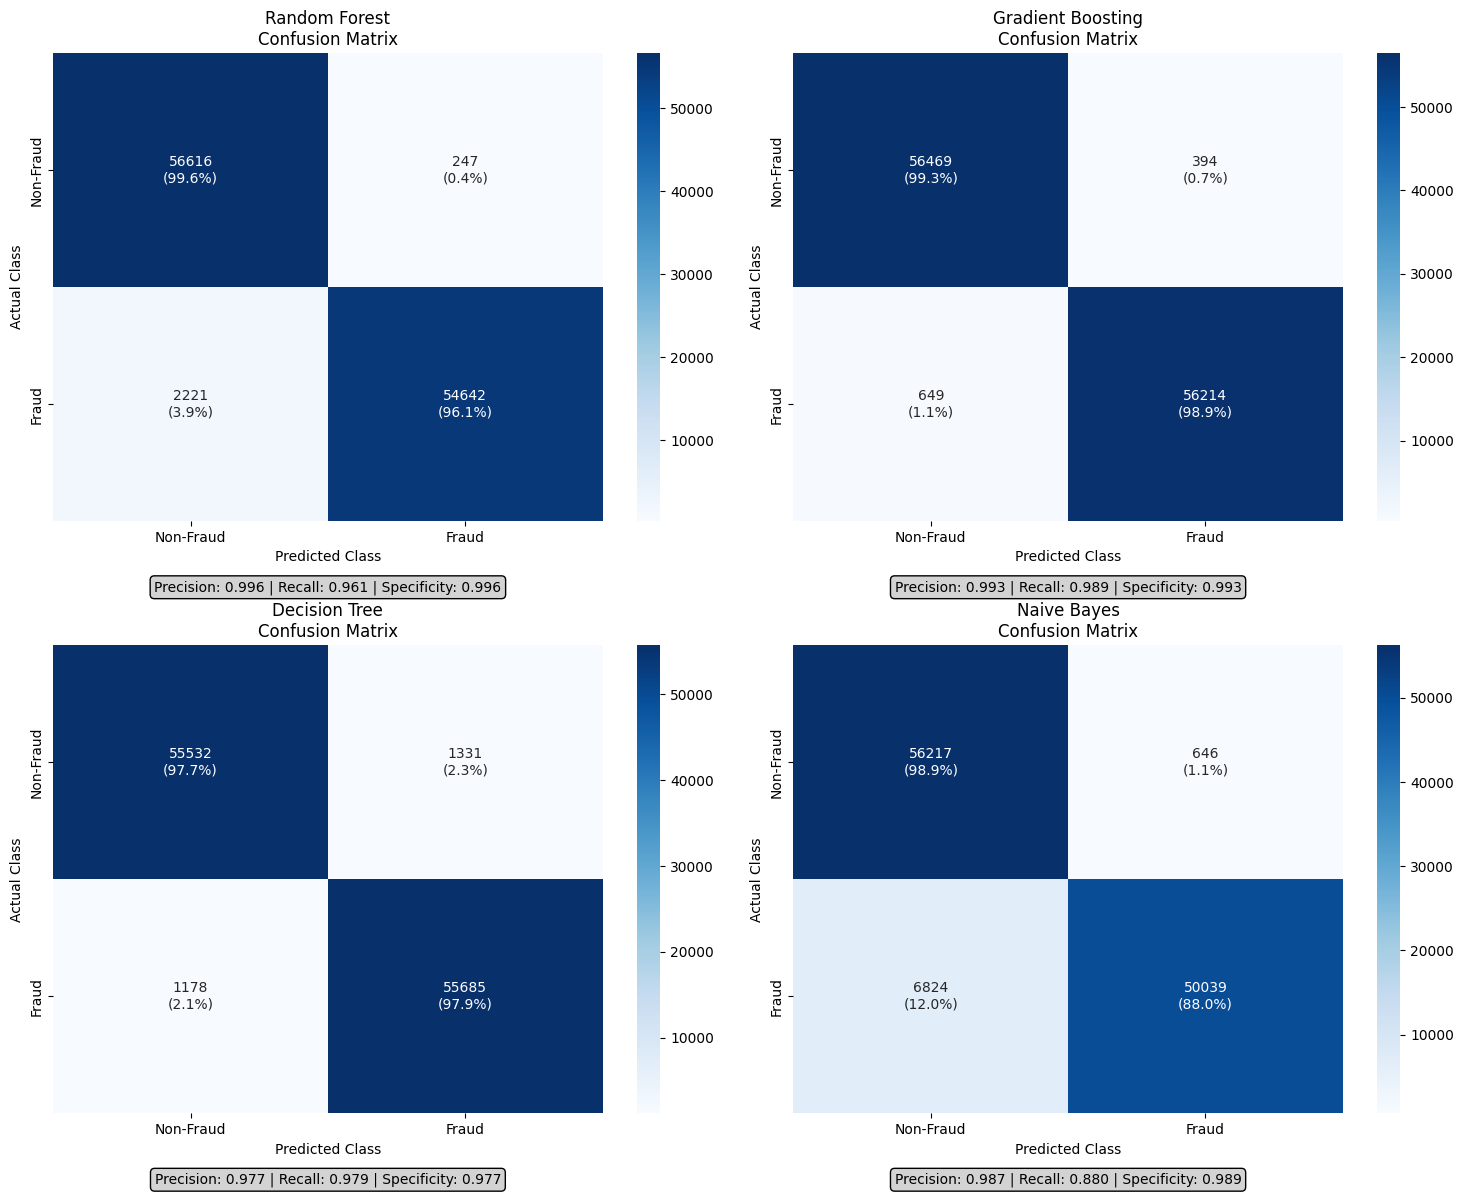

In [11]:
print("\n=== DETAILED CONFUSION MATRICES ===")

# Class labels for better interpretation
class_labels = ['Non-Fraud', 'Fraud']

# Create confusion matrix plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create annotations with both counts and percentages
    annotations = []
    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            annotations.append([f"{cm[row, col]}\n({cm_percent[row, col]:.1f}%)"])

    annotations = np.asarray(annotations).reshape(cm.shape)

    # Plot confusion matrix
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(f'{name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted Class')
    axes[i].set_ylabel('Actual Class')

    # Calculate and display key metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Add metrics text below the heatmap
    metrics_text = f"Precision: {precision:.3f} | Recall: {recall:.3f} | Specificity: {specificity:.3f}"
    axes[i].text(0.5, -0.15, metrics_text, transform=axes[i].transAxes,
                ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    print(f"\n{name} Detailed Metrics:")
    print(f"  True Negatives (Correct Non-Fraud): {tn:,}")
    print(f"  False Positives (False Fraud Alerts): {fp:,}")
    print(f"  False Negatives (Missed Fraud): {fn:,}")
    print(f"  True Positives (Caught Fraud): {tp:,}")
    print(f"  Precision (Fraud Detection Accuracy): {precision:.3f}")
    print(f"  Recall (Fraud Catch Rate): {recall:.3f}")
    print(f"  Specificity (Non-Fraud Accuracy): {specificity:.3f}")

plt.tight_layout()
plt.show()


=== MODEL EVALUATION & COMPARISON ===


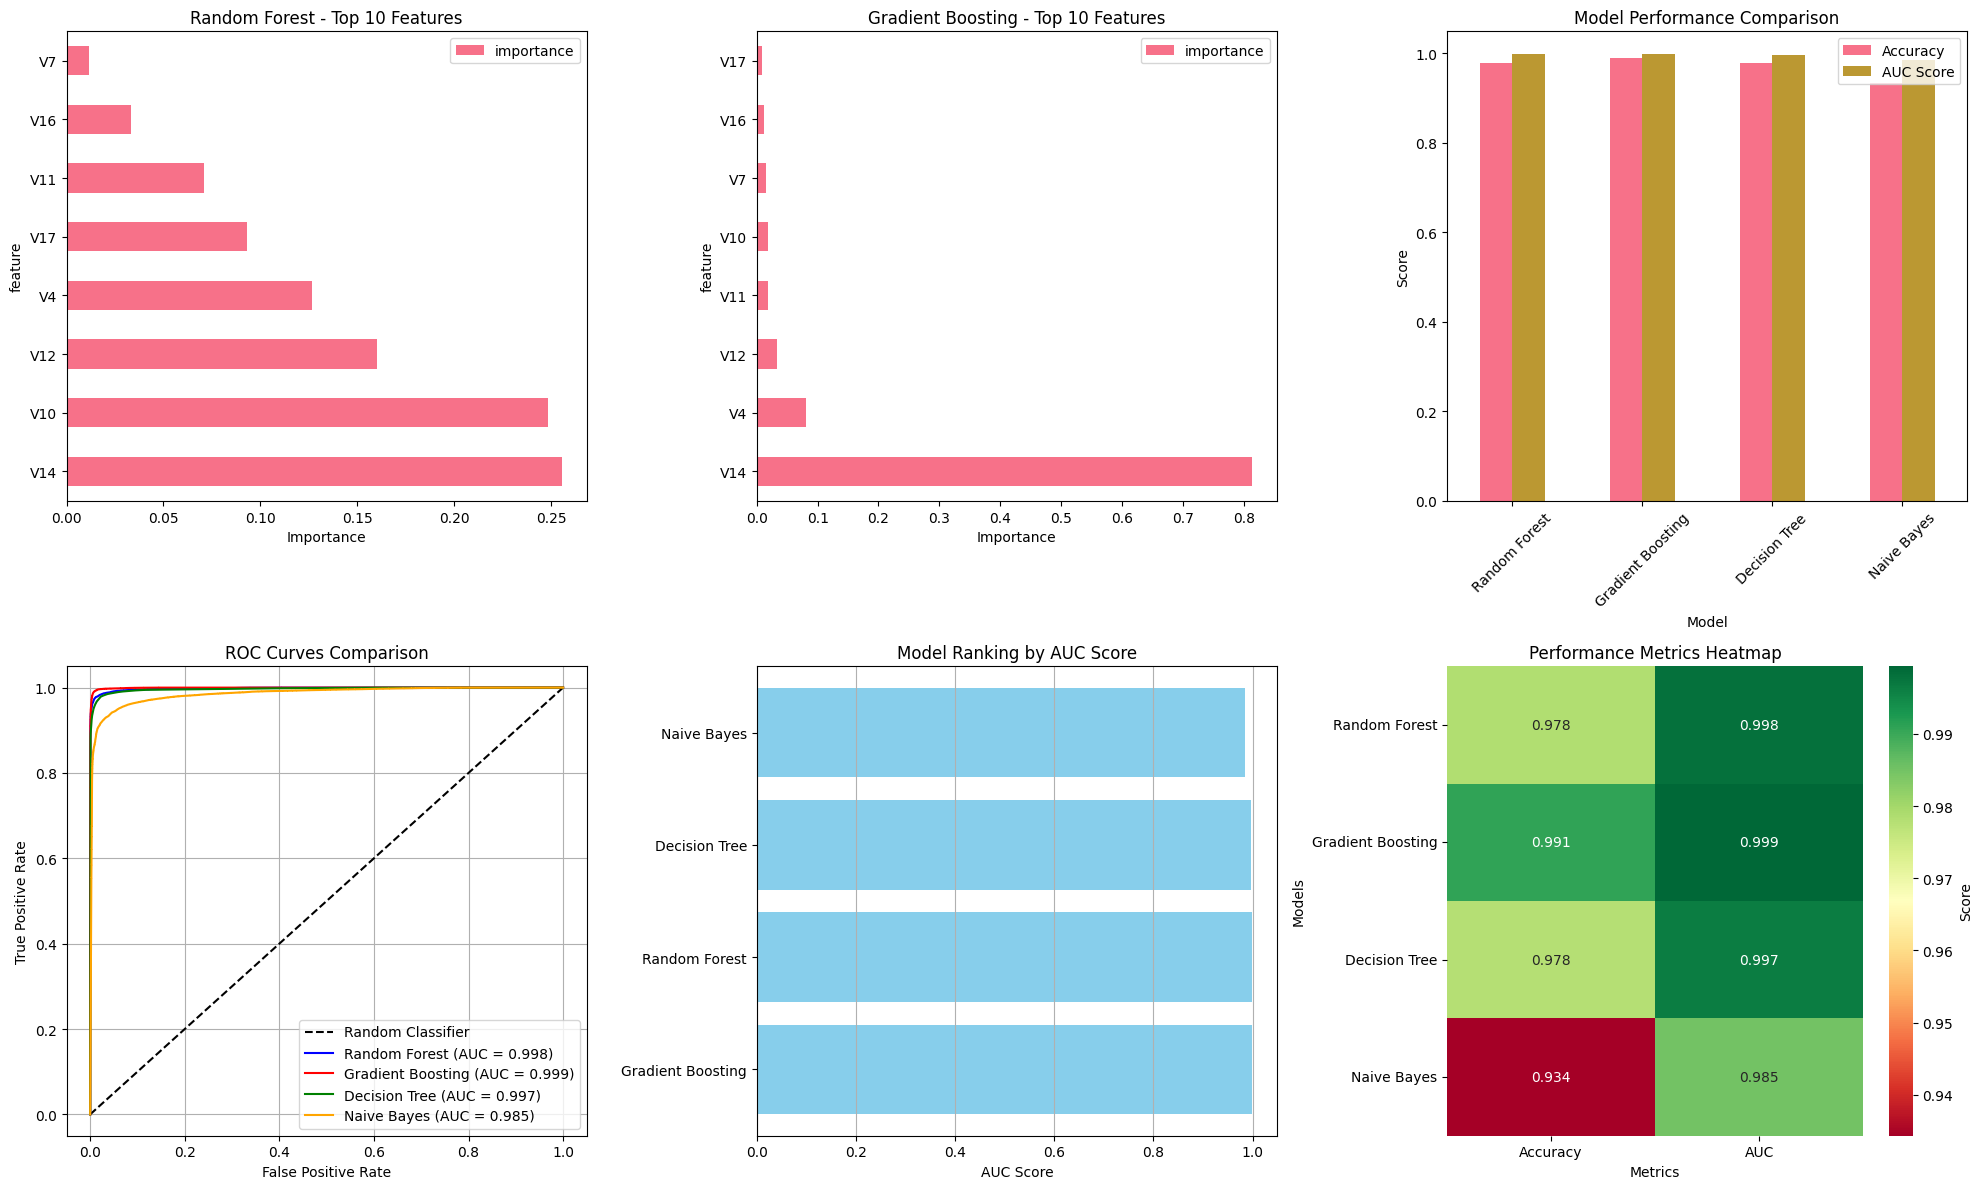

In [12]:
print("\n=== MODEL EVALUATION & COMPARISON ===")

# Create evaluation plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Feature importance comparison for tree-based models
tree_models = ['Random Forest', 'Gradient Boosting', 'Decision Tree']
available_tree_models = [model for model in tree_models if model in results.keys()]

for i, model_name in enumerate(available_tree_models[:2]):  # Plot first 2 tree models
    if model_name in results:
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': results[model_name]['model'].feature_importances_
        }).sort_values('importance', ascending=False).head(10)

        importance_df.plot(x='feature', y='importance', kind='barh', ax=axes[0, i])
        axes[0, i].set_title(f'{model_name} - Top 10 Features')
        axes[0, i].set_xlabel('Importance')

# Model comparison
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'AUC Score': [results[name]['auc'] for name in results.keys()]
})

model_comparison.set_index('Model').plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('Model Performance Comparison')
axes[0, 2].set_ylabel('Score')
axes[0, 2].legend()
axes[0, 2].tick_params(axis='x', rotation=45)

# ROC Curve comparison
from sklearn.metrics import roc_curve
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')

colors = ['blue', 'red', 'green', 'orange']
for i, (name, result) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    axes[1, 0].plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.3f})',
                   color=colors[i % len(colors)])

axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Model ranking by different metrics
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'AUC': [results[name]['auc'] for name in results.keys()]
})

# Sort by AUC and create ranking
metrics_df_sorted = metrics_df.sort_values('AUC', ascending=False)
axes[1, 1].barh(range(len(metrics_df_sorted)), metrics_df_sorted['AUC'], color='skyblue')
axes[1, 1].set_yticks(range(len(metrics_df_sorted)))
axes[1, 1].set_yticklabels(metrics_df_sorted['Model'])
axes[1, 1].set_xlabel('AUC Score')
axes[1, 1].set_title('Model Ranking by AUC Score')
axes[1, 1].grid(True, axis='x')

# Performance metrics heatmap
metrics_matrix = metrics_df.set_index('Model')[['Accuracy', 'AUC']]
sns.heatmap(metrics_matrix, annot=True, cmap='RdYlGn', ax=axes[1, 2],
            fmt='.3f', cbar_kws={'label': 'Score'})
axes[1, 2].set_title('Performance Metrics Heatmap')
axes[1, 2].set_xlabel('Metrics')
axes[1, 2].set_ylabel('Models')

plt.tight_layout()
plt.show()

In [13]:
print("\n=== SUMMARY & INSIGHTS ===")

# Find best performing model
best_model_name = max(results.keys(), key=lambda x: results[x]['auc'])
best_model_auc = results[best_model_name]['auc']
best_model_acc = results[best_model_name]['accuracy']

print("1. FRAUD DETECTION MODEL PERFORMANCE:")
print(f"   Best Model: {best_model_name} (AUC: {best_model_auc:.3f}, Accuracy: {best_model_acc:.1%})")
print("   All Models:")
for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
    print(f"      • {name}: {result['accuracy']:.1%} accuracy, {result['auc']:.3f} AUC")

print(f"\n2. MERCHANT CATEGORY ANALYSIS:")
best_category = merchant_fraud['Fraud_Rate'].idxmin()
worst_category = merchant_fraud['Fraud_Rate'].idxmax()
print(f"   ✅ Safest Category: {best_category} ({merchant_fraud.loc[best_category, 'Fraud_Rate']:.1%} fraud rate)")
print(f"   ⚠️  Riskiest Category: {worst_category} ({merchant_fraud.loc[worst_category, 'Fraud_Rate']:.1%} fraud rate)")

print(f"\n3. TRANSACTION TYPE ANALYSIS:")
safest_type = trans_type_fraud['Fraud_Rate'].idxmin()
riskiest_type = trans_type_fraud['Fraud_Rate'].idxmax()
print(f"   ✅ Safest Transaction: {safest_type} ({trans_type_fraud.loc[safest_type, 'Fraud_Rate']:.1%} fraud rate)")
print(f"   ⚠️  Riskiest Transaction: {riskiest_type} ({trans_type_fraud.loc[riskiest_type, 'Fraud_Rate']:.1%} fraud rate)")

# Feature importance from best model
if hasattr(results[best_model_name]['model'], 'feature_importances_'):
    best_model_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': results[best_model_name]['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n4. KEY FEATURES (from {best_model_name}):")
    print("   Top 5 most important features:")
    for i, row in best_model_importance.head(5).iterrows():
        print(f"      {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n=== BUSINESS RECOMMENDATIONS ===")
print(f"DEPLOYMENT: Use {best_model_name} for production fraud detection")
print(f"MONITORING: Focus on {worst_category} merchant category (highest risk)")
print(f"VERIFICATION: Add extra checks for {riskiest_type} transactions")
print(f"OPTIMIZATION: Enhance data collection for top important features")
print(f"ENSEMBLE: Consider combining multiple models for better performance")

# Get confusion matrix metrics for best model
cm_best = confusion_matrix(y_test, results[best_model_name]['predictions'])
tn, fp, fn, tp = cm_best.ravel()
print(f"\n{best_model_name} FRAUD DETECTION PERFORMANCE:")
print(f"   • Fraud Cases Caught: {tp:,} out of {tp+fn:,} ({tp/(tp+fn)*100:.1f}%)")
print(f"   • False Alarms: {fp:,} out of {tn+fp:,} transactions ({fp/(tn+fp)*100:.1f}%)")
print(f"   • Overall Accuracy: {(tp+tn)/(tp+tn+fp+fn)*100:.1f}%")


=== SUMMARY & INSIGHTS ===
1. FRAUD DETECTION MODEL PERFORMANCE:
   Best Model: Gradient Boosting (AUC: 0.999, Accuracy: 99.1%)
   All Models:
      • Gradient Boosting: 99.1% accuracy, 0.999 AUC
      • Random Forest: 97.8% accuracy, 0.998 AUC
      • Decision Tree: 97.8% accuracy, 0.997 AUC
      • Naive Bayes: 93.4% accuracy, 0.985 AUC

2. MERCHANT CATEGORY ANALYSIS:
   ✅ Safest Category: Cat_B (0.0% fraud rate)
   ⚠️  Riskiest Category: Cat_A (50.1% fraud rate)

3. TRANSACTION TYPE ANALYSIS:
   ✅ Safest Transaction: Medium (49.2% fraud rate)
   ⚠️  Riskiest Transaction: Very_Large (50.0% fraud rate)

4. KEY FEATURES (from Gradient Boosting):
   Top 5 most important features:
      1. V14: 0.8141
      4. V4: 0.0803
      3. V12: 0.0330
      5. V11: 0.0188
      2. V10: 0.0178

=== BUSINESS RECOMMENDATIONS ===
DEPLOYMENT: Use Gradient Boosting for production fraud detection
MONITORING: Focus on Cat_A merchant category (highest risk)
VERIFICATION: Add extra checks for Very_Large tr